# Model Worfklow from LyricsGenreRecognition Project

## 1. Input Data, split in train and test set
- Input contains: genre column, full lyrics column, and artist column
- Split data into training set (80%) and test set (20%)
- For testing, use a 10% genre-stratified sample of dataset

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

GRANUULARITY = 5
SEED = 42
DEBUGGING_SUBSAMPLE = 0.1

full = pd.read_csv("../../data/poptrag_lyrics_genres_corpus_filtered_english.csv")
selected = full[
    [f"cat{GRANUULARITY}", "full_lyrics", "track.s.firstartist.name"]
].rename(
    {
        f"cat{GRANUULARITY}": "genre",
        "full_lyrics": "lyrics",
        "track.s.firstartist.name": "artist",
    },
    axis=1,
)

# for debugging
selected, _ = train_test_split(
    selected,
    train_size=DEBUGGING_SUBSAMPLE,
    random_state=SEED,
    stratify=selected["genre"],
    shuffle=True,
)


print(selected.keys())
print(f"Shape before subsampling: {selected.shape}")
print(selected["genre"].value_counts(normalize=False))

Index(['genre', 'lyrics', 'artist'], dtype='str')
Shape before subsampling: (11193, 3)
genre
rock          5811
pop           2603
metal         1080
electronic     949
hip hop        750
Name: count, dtype: int64


Train shape: (8927, 3)
colums: Index(['genre', 'lyrics', 'artist'], dtype='str')
            freq   relfreq
genre                     
rock        4663  0.522348
pop         2058  0.230537
metal        853  0.095553
hip hop      595  0.066652
electronic   758  0.084911
Test shape: (2266, 3)
colums: Index(['genre', 'lyrics', 'artist'], dtype='str')
            freq   relfreq
genre                     
rock        1148  0.506620
pop          545  0.240512
metal        227  0.100177
hip hop      155  0.068402
electronic   191  0.084289


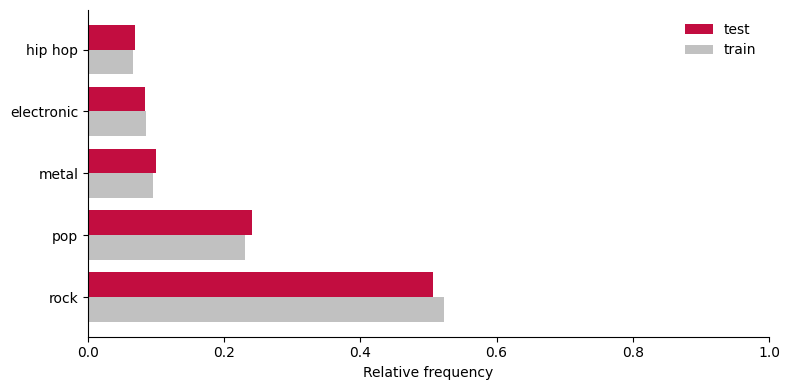

In [ ]:
from helpers.split_group_stratified_and_join import (
    split_group_stratified_and_join,
    plot_genre_distribution,
)

labels_and_group = selected.rename(columns={"genre": "label", "artist": "group"})
train, test, _, _ = split_group_stratified_and_join(
    labels_and_group, selected, test_size=0.2, random_state=SEED
)


def print_set_info(name, data, outcome_col):
    print(f"{name} shape: {data.shape}")
    print(f"colums: {data.keys()}")
    freq = data[outcome_col].value_counts(normalize=False)
    relfreq = data[outcome_col].value_counts(normalize=True)
    frequencies = pd.concat(
        [freq, relfreq], axis=1, keys=["freq", "relfreq"]
    ).sort_index(ascending=False, axis=0, inplace=False)
    print(frequencies)


print_set_info("Train", train, "genre")
print("=" * 60)
print_set_info("Test", test, "genre")
dist = plot_genre_distribution(train["genre"], test["genre"])

## 2. Evaluate Random Baseline on Test Set
- Calculate the distribution of genres in the training set
- Use this distribution to create a random baseline prediction for the test set
- Evaluate the random baseline predictions using precision, recall, and macro F1-score, and Cohen's Kappa

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, cohen_kappa_score

p = train["genre"].value_counts(normalize=True)
y_test = test["genre"]


def sample_random_baseline(probs, n, seed=SEED):
    rng = np.random.default_rng(seed)
    labels = probs.index.to_numpy()
    weights = probs.to_numpy()
    sampled = rng.choice(labels, size=n, p=weights)
    return pd.Series(sampled, index=y_test.index, name="pred")


y_pred = sample_random_baseline(p, y_test.shape[0], seed=SEED)


def print_evaluation_metrics(y_true, y_pred):
    print(f"F1 macro: {f1_score(y_true, y_pred, average='macro'):.3f}")
    print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.3f}")
    print(f"Recall: {recall_score(y_true, y_pred, average='macro'):.3f}")
    print(f"Cohen's kappa: {cohen_kappa_score(y_true, y_pred):.3f}")


print_evaluation_metrics(y_test, y_pred)

F1 macro: 0.187
Precision: 0.187
Recall: 0.188
Cohen's kappa: -0.012


## 3. Construct Features from Lyrics on Train Set and Apply to Test Set
- here: replicate ngram-based approach by Fell and Sporleder (2014)
- later: experiment with new ideas

In [56]:
import pandas as pd
from helpers.n_gram_features import build_ngram_features, count_final_ngrams_lyrics

MIN_ARTISTS = 50
TOP_K_NGRAMS = 50

# takes 3min
# X_train = build_ngram_features(train, MIN_ARTISTS, TOP_K_NGRAMS)
# X_train.to_csv("X_train_prototype.csv", index=True)
X_train = pd.read_csv("X_train_prototype.csv", index_col=0)
y_train = train["genre"]

X_test = count_final_ngrams_lyrics(test["lyrics"], X_train.columns)
y_test = test["genre"]

print(f"Number of ngram-count features: {X_train.shape[1]}")
X_test.shape[1] == X_train.shape[1]  # should be True

Number of ngram-count features: 303


True

## 4. Model Training on Train Set	
- model Logistic Regression with elastic net regularization
- perform a Bayesian hyperparameter optimization with 5-fold cross-validation on the training set
- select best model according to 1-SE rule and macro F1-score

In [ ]:
from helpers.training_pipeline import train_model_with_optimization


param_space = {"C": [-3, 2], "l1_ratio": [0, 1], "target_ratio": [0.08, 0.48]}

# todo bayeian optimization: in bayes phase use n_jobs=nfolds
# takes 5 min on the 10% subset with n_jobs=9
best_pipeline, optimization_results = train_model_with_optimization(
    X_train,
    y_train,
    param_space=param_space,
    n_initial=3,
    n_iterations=2,
    cv=3,
    random_state=SEED,
    n_jobs=9,
    checkpoint_dir="./models/checkpoints_ngram_granularity_5",
)

print(f"\nBest parameters (1-SE rule): {optimization_results['best_params']}")
print(f"Best CV score: {optimization_results['best_score']:.4f}")
print(f"\nAbsolute best parameters: {optimization_results['absolute_best_params']}")
print(f"Absolute best score: {optimization_results['absolute_best_score']:.4f}")

Starting Initial Phase:
Using 9 parallel jobs
Initial evaluation 1/3
Score: 0.3360
------------------------------------------------------------
Initial evaluation 2/3
Score: 0.3229
------------------------------------------------------------
Initial evaluation 3/3
Score: 0.3744
------------------------------------------------------------
Starting Bayesian Phase:
Bayesian iteration 1/2
Score: 0.3690
------------------------------------------------------------
Bayesian iteration 2/2
Score: 0.3492
------------------------------------------------------------
Selecting best parameters according to 1-SE rule...
Retraining best pipeline on full training data...


N:\Materialien\Promotion\LyricsGenreRecognition\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(



Best parameters (1-SE rule): {'C': np.float64(92.00084698000711), 'l1_ratio': np.float64(0.32470981591860953), 'target_ratio': np.float64(2.680055182757888)}
Best CV score: 0.3690

Absolute best parameters: {'C': np.float64(5.388077452832789), 'l1_ratio': np.float64(0.40464523157434873), 'target_ratio': np.float64(2.9034756107975843)}
Absolute best score: 0.3744


N:\Materialien\Promotion\LyricsGenreRecognition\venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## 5. Evaluate Best Model on Test Set

In [ ]:
from helpers.training_pipeline import (
    evaluate_model,
    save_training_artifacts,
    visualize_results,
)

#todo: inspect the model coefficients, improve confmat

print("Evaluating on test set...")
evaluation_results = evaluate_model(best_pipeline, X_test, y_test)

print(f"\nTest set macro F1: {evaluation_results['macro_f1']:.3f}")
print(f"Test set Cohen's kappa: {evaluation_results['cohen_kappa']:.3f}")
print("\nClassification Report:")
print(pd.DataFrame(evaluation_results["classification_report"]).transpose())

Evaluating on test set...

Test set macro F1: 0.380
Test set Cohen's kappa: 0.182

Classification Report:
              precision    recall  f1-score      support
electronic     0.161616  0.083770  0.110345   191.000000
hip hop        0.493671  0.503226  0.498403   155.000000
metal          0.346457  0.387665  0.365904   227.000000
pop            0.353687  0.563303  0.434536   545.000000
rock           0.561443  0.433798  0.489435  1148.000000
accuracy       0.435569  0.435569  0.435569     0.435569
macro avg      0.383375  0.394352  0.379725  2266.000000
weighted avg   0.451602  0.435569  0.432516  2266.000000


In [ ]:
# todo save training data frame also
output_dir = save_training_artifacts(
    best_pipeline,
    optimization_results,
    evaluation_results,
    X_train,
    y_train,
    X_test,
    y_test,
    output_dir="./models/prototype_g5_10percent_fs",
)

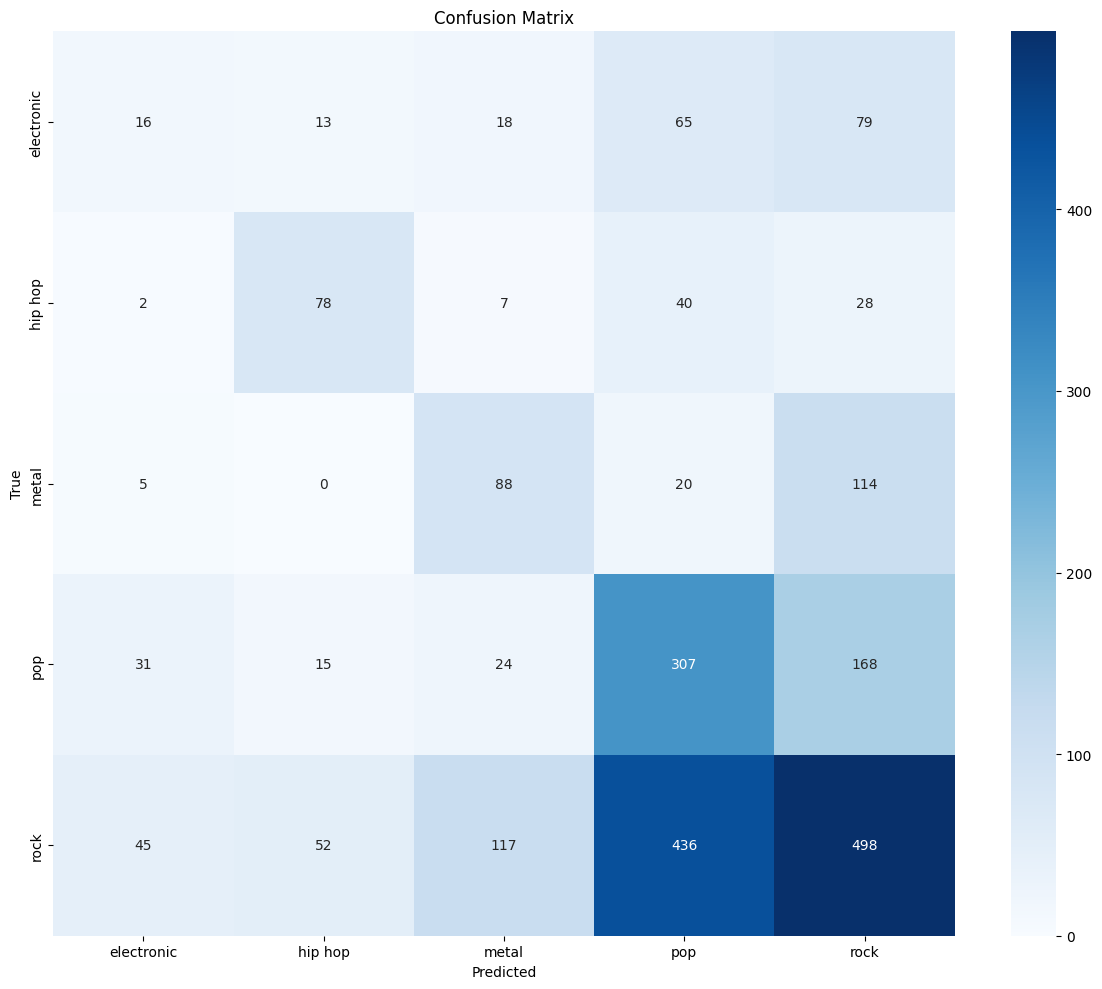

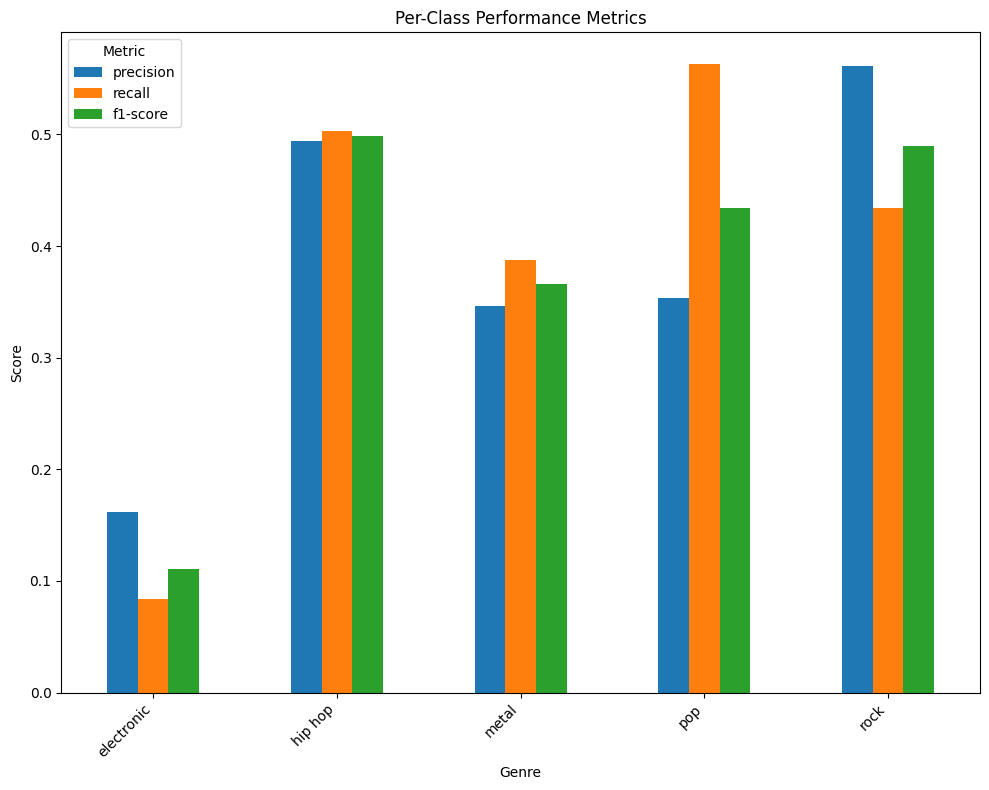

In [62]:
eval_viz = visualize_results(evaluation_results, y_test, output_dir=output_dir)